In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import re
from collections import Counter
import random
import numpy as np
from itertools import islice
import pandas as pd
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def set_seed(seed=42):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(42)

In [2]:
def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text.split()



In [3]:
df = pd.read_csv("data/imdb.csv")

df["label"] = df["sentiment"].map({"positive": 1, "negative": 0})

pos_data = df[df['label'] == 1].iloc[:2500]
neg_data = df[df['label'] == 0].iloc[:2500]

train_data = pd.concat([pos_data, neg_data]).sample(frac=1, random_state=42).reset_index(drop=True)

pos_test = df[df['label'] == 1].iloc[2500:3000]
neg_test = df[df['label'] == 0].iloc[2500:3000]
test_data = pd.concat([pos_test, neg_test]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Train size:", len(train_data), "Test size:", len(test_data))
print("Train label:", train_data['label'].value_counts().to_dict())
print("Test label:", test_data['label'].value_counts().to_dict())


Train size: 5000 Test size: 1000
Train label: {1: 2500, 0: 2500}
Test label: {0: 500, 1: 500}


In [4]:
def clean(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text

In [5]:
train_texts = train_data["review"].apply(clean).tolist()
train_labels = train_data["label"].tolist()

test_texts = test_data["review"].apply(clean).tolist()
test_labels = test_data["label"].tolist()

# Bag of Words

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = CountVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

# Train Logistic Regression

In [7]:
clf = LogisticRegression(max_iter=200)
clf.fit(X_train, train_labels)

train_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

train_acc = accuracy_score(train_labels, train_preds)
test_acc = accuracy_score(test_labels, test_preds)

print(f"[Train] Accuracy: {train_acc:.4f}")
print(f"[Test]  Accuracy: {test_acc:.4f}")

[Train] Accuracy: 0.8280
[Test]  Accuracy: 0.8040


# Saatnya Word Embeddings beraksi

In [8]:
counter = Counter()
for review in train_data["review"]:
    counter.update(tokenize(review))

vocab_size = 10000
special_tokens = {"<pad>": 0, "<unk>": 1}
vocab = {word: idx + 2 for idx, (word, _) in enumerate(counter.most_common(vocab_size - 2))}
vocab.update(special_tokens)

def encode(text):
    tokens = tokenize(text)
    ids = [vocab.get(token, vocab["<unk>"]) for token in tokens]
    return torch.tensor(ids, dtype=torch.long)

maxlen = 20
def collate_fn(batch):
    inputs = [encode(sample["text"])[:maxlen] for sample in batch]
    inputs = [torch.cat([seq, torch.zeros(maxlen - len(seq), dtype=torch.long)]) if len(seq) < maxlen else seq for seq in inputs]
    labels = [sample["label"] for sample in batch]
    return torch.stack(inputs), torch.tensor(labels, dtype=torch.float32)

# Membangun IMBD Dataset

In [9]:
from torch.utils.data import Dataset

class IMDBDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        return {"text": row["review"], "label": row["label"]}

    def __len__(self):
        return len(self.data)

In [10]:
train_dataset = IMDBDataset(train_data)
test_dataset = IMDBDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


# Load Pre-Trained GloVe Word Embedding

In [11]:
def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf8') as f:
        for line in tqdm(f,desc='Loading GloVe Embedding'):
            values = line.strip().split()
            word = values[0]
            vector = torch.tensor([float(x) for x in values[1:]], dtype=torch.float32)
            embeddings_index[word] = vector
    return embeddings_index


In [12]:
def build_embedding_matrix(vocab, embeddings_index, embedding_dim):
    embedding_matrix = torch.randn(len(vocab), embedding_dim) * 0.01
    embedding_matrix[vocab["<pad>"]] = torch.zeros(embedding_dim)

    for word, idx in tqdm(vocab.items(), desc="Sedang membangun Embedding Matrix"):
        if word in embeddings_index:
            embedding_matrix[idx] = embeddings_index[word]
    return embedding_matrix


In [13]:
class GloVeIMDBClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim):
        super().__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.rnn(x)
        return self.sigmoid(self.fc(h_n.squeeze(0)))


# Let's Train !!!

Loading GloVe Embedding: 400000it [00:13, 29221.88it/s]
Sedang membangun Embedding Matrix: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 167027.88it/s]


[Train] Epoch 1 - Loss: 0.6963 | Acc: 0.5192
[Test] Epoch 1 - Loss: 0.6867 | Acc: 0.5360
[Train] Epoch 2 - Loss: 0.6749 | Acc: 0.5792
[Test] Epoch 2 - Loss: 0.7022 | Acc: 0.5140
[Train] Epoch 3 - Loss: 0.6153 | Acc: 0.6640
[Test] Epoch 3 - Loss: 0.7168 | Acc: 0.5590
[Train] Epoch 4 - Loss: 0.4942 | Acc: 0.7622
[Test] Epoch 4 - Loss: 0.8207 | Acc: 0.5600
[Train] Epoch 5 - Loss: 0.3449 | Acc: 0.8558
[Test] Epoch 5 - Loss: 1.0524 | Acc: 0.5460
[Train] Epoch 6 - Loss: 0.2263 | Acc: 0.9098
[Test] Epoch 6 - Loss: 1.2891 | Acc: 0.5120
[Train] Epoch 7 - Loss: 0.1477 | Acc: 0.9462
[Test] Epoch 7 - Loss: 1.3413 | Acc: 0.5510
[Train] Epoch 8 - Loss: 0.0826 | Acc: 0.9714
[Test] Epoch 8 - Loss: 1.5988 | Acc: 0.5350
[Train] Epoch 9 - Loss: 0.0433 | Acc: 0.9894
[Test] Epoch 9 - Loss: 1.8500 | Acc: 0.5220
[Train] Epoch 10 - Loss: 0.0261 | Acc: 0.9926
[Test] Epoch 10 - Loss: 2.0262 | Acc: 0.5290


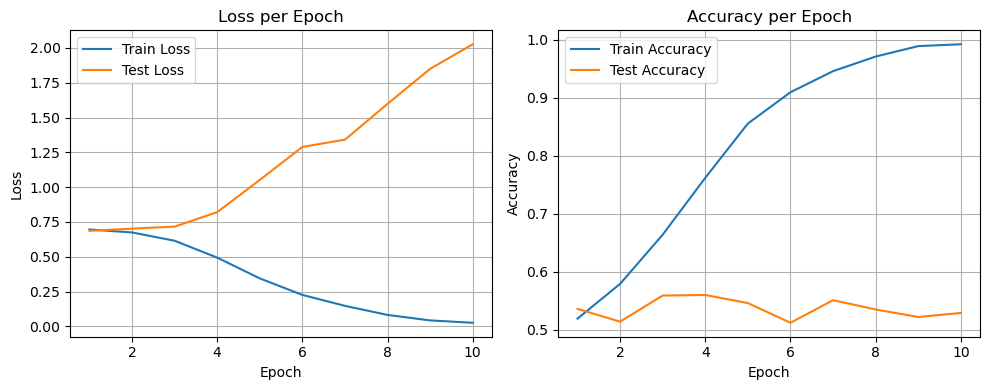

In [14]:

import matplotlib.pyplot as plt

glove_path = "pretrains/glove.6B/glove.6B.100d.txt"
embedding_dim = 100
hidden_dim = 128

glove_index = load_glove_embeddings(glove_path)
embedding_matrix = build_embedding_matrix(vocab, glove_index, embedding_dim)

model = GloVeIMDBClassifier(embedding_matrix, hidden_dim)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []



epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for x_batch, y_batch in train_loader:
        pred = model(x_batch).squeeze()
        loss = loss_fn(pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_preds.extend((pred > 0.5).int().tolist())
        all_labels.extend(y_batch.int().tolist())

    train_acc = accuracy_score(all_labels, all_preds)
    avg_loss = total_loss / len(train_loader)
    
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)
    
    print(f"[Train] Epoch {epoch+1} - Loss: {avg_loss:.4f} | Acc: {train_acc:.4f}")

    # Evaluation on test set
    model.eval()
    all_preds_test = []
    all_labels_test = []
    total_test_loss = 0
    
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            pred = model(x_batch).squeeze()
            loss = loss_fn(pred, y_batch)

            total_test_loss += loss.item()
            
            all_preds_test.extend((pred > 0.5).int().tolist())
            all_labels_test.extend(y_batch.int().tolist())

    test_acc = accuracy_score(all_labels_test, all_preds_test)
    
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)
    print(f"[Test] Epoch {epoch+1} - Loss: {avg_test_loss:.4f} | Acc: {test_acc:.4f}")
    
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)

# --- Plotting Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()